In [11]:
import keras
import numpy as np
import tensorflow as tf
import datetime
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from functools import partial
import os
import matplotlib.pyplot as plt
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
X, y = fetch_california_housing(return_X_y=True)

In [3]:
X = StandardScaler().fit_transform(X)
X.shape

(20640, 8)

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=42, train_size=0.75)

In [5]:
from functools import partial
def Model():
    Dense =  partial(
        keras.layers.Dense,
        activation = keras.activations.selu,
        kernel_initializer = keras.initializers.lecun_normal     
    )
    model = keras.models.Sequential(
        layers=[
            Dense(16),
            Dense(8),
            Dense(4),
            Dense(2),
            keras.layers.Dense(1)
        ]
    )
    return model

## customizando modelos

In [6]:
def huder_fn(ytrue, ypred):
    error = ytrue - ypred
    is_small_error = tf.abs(error)<1
    squared_loss   = tf.square(error)/2
    linear_loss    = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [7]:
model = Model()
path  ='logs/fit/'+datetime.datetime.now().strftime("%Y_%m_%d - %H_%M_%S")
tensorboard = keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1)
model.compile(
    loss=huder_fn,
    optimizer=keras.optimizers.RMSprop(),
)
model.fit(xtrain, ytrain, batch_size=32, epochs=20, callbacks=[tensorboard])

Epoch 1/20


484/484 [==============================] - 5s 6ms/step - loss: 0.4340
Epoch 2/20
484/484 [==============================] - 2s 4ms/step - loss: 0.2193
Epoch 3/20
484/484 [==============================] - 2s 4ms/step - loss: 0.1953
Epoch 4/20
484/484 [==============================] - 2s 3ms/step - loss: 0.1854
Epoch 5/20
484/484 [==============================] - 2s 3ms/step - loss: 0.1794
Epoch 6/20
484/484 [==============================] - 2s 3ms/step - loss: 0.1752
Epoch 7/20
484/484 [==============================] - 2s 4ms/step - loss: 0.1713
Epoch 8/20
484/484 [==============================] - 2s 4ms/step - loss: 0.1677
Epoch 9/20
484/484 [==============================] - 2s 3ms/step - loss: 0.1647
Epoch 10/20
484/484 [==============================] - 1s 3ms/step - loss: 0.1615
Epoch 11/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1582
Epoch 12/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1551
Epoch 13/20
484/484 [===============

In [8]:
predict = model.predict(xtest)

162/162 [==============================] - 0s 1ms/step


In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
print(tf.math.reduce_std(y))

result = f'''
mean_absolute_error = {mean_absolute_error(ytest ,predict)}
mean_squared_error  = {mean_squared_error(ytest, predict)}
r2_score            = {r2_score(ytest, predict)}

'''
print(result)

tf.Tensor(1.153928204041225, shape=(), dtype=float64)

mean_absolute_error = 0.40067223891047354
mean_squared_error  = 0.3350953113298305
r2_score            = 0.7467573107671217




In [10]:
def create_huber(threshold=1.0):
    def huder_fn(ytrue, ypred):
        error = ytrue - ypred
        is_small_error = tf.abs(error) < threshold
        squared_loss   = tf.square(error) / 2
        linear_loss    = threshold * tf.abs(error) - threshold**2 /2
        return tf.where( is_small_error, squared_loss, linear_loss)
    return  huder_fn

In [11]:
model = Model()

model.compile(
    loss=create_huber(2.0),
    optimizer=keras.optimizers.RMSprop(),
)
model.fit(xtrain, ytrain, batch_size=32, epochs=20, callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

Epoch 1/20
484/484 [==============================] - 1s 1ms/step - loss: 0.4229
Epoch 2/20
484/484 [==============================] - 1s 1ms/step - loss: 0.2280
Epoch 3/20
484/484 [==============================] - 1s 1ms/step - loss: 0.2164
Epoch 4/20
484/484 [==============================] - 1s 1ms/step - loss: 0.2067
Epoch 5/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1982
Epoch 6/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1900
Epoch 7/20
484/484 [==============================] - 1s 1ms/step - loss: 0.1834
Epoch 8/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1792
Epoch 9/20
484/484 [==============================] - 1s 1ms/step - loss: 0.1768
Epoch 10/20
484/484 [==============================] - 1s 1ms/step - loss: 0.1748
Epoch 11/20
484/484 [==============================] - 1s 1ms/step - loss: 0.1733
Epoch 12/20
484/484 [==============================] - 1s 1ms/step - loss: 0.1720
Epoch 13/20
484/484 [====

In [12]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
print(tf.math.reduce_std(y))

result = f'''
mean_absolute_error = {mean_absolute_error(ytest ,predict)}
mean_squared_error  = {mean_squared_error(ytest, predict)}
r2_score            = {r2_score(ytest, predict)}

'''
print(result)

tf.Tensor(1.153928204041225, shape=(), dtype=float64)

mean_absolute_error = 0.40067223891047354
mean_squared_error  = 0.3350953113298305
r2_score            = 0.7467573107671217




construindo por meio de class

In [13]:
class HuderLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, ytrue, ypred):
        error = ytrue - ypred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss   = tf.square(error) / 2
        linear_loss    = self.threshold * tf.abs(error) - self.threshold**2 /2
        return tf.where( is_small_error, squared_loss, linear_loss)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}
        

In [14]:
model = Model()

model.compile(
    loss=HuderLoss(2.0),
    optimizer=keras.optimizers.RMSprop(),
)
model.fit(xtrain, ytrain, batch_size=32, epochs=20)

Epoch 1/20


484/484 [==============================] - 1s 1ms/step - loss: 0.4439
Epoch 2/20
484/484 [==============================] - 1s 1ms/step - loss: 0.2406
Epoch 3/20
484/484 [==============================] - 1s 1ms/step - loss: 0.2250
Epoch 4/20
484/484 [==============================] - 1s 1ms/step - loss: 0.2163
Epoch 5/20
484/484 [==============================] - 1s 1ms/step - loss: 0.2108
Epoch 6/20
484/484 [==============================] - 1s 1ms/step - loss: 0.2072
Epoch 7/20
484/484 [==============================] - 1s 2ms/step - loss: 0.2042
Epoch 8/20
484/484 [==============================] - 1s 2ms/step - loss: 0.2015
Epoch 9/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1997
Epoch 10/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1978
Epoch 11/20
484/484 [==============================] - 1s 2ms/step - loss: 0.1961
Epoch 12/20
484/484 [==============================] - 1s 1ms/step - loss: 0.1939
Epoch 13/20
484/484 [===============

### funcoes de ativação customizadas, inicializadores, reguladores e restrição

In [15]:
def my_softplus(z):
    return tf.math.log(tf.exp(z)+1.0)

def my_myglorot_initializer(shape, dtype=tf.float32):
    stdev = tf.sqrt(2. / (shape[0]+shape[1]))
    return tf.random.normal(shape=shape, stddev=stdev, dtype=dtype)

def my_regulirizerL1(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights):
    return tf.where( weights < 0., tf.zeros_like(weights), weights)


In [12]:
def Model():
    Dense =  partial(
        keras.layers.Dense,
        activation = my_softplus,
        kernel_initializer = my_myglorot_initializer,
        kernel_regularizer = my_regulirizerL1,
        kernel_constraint  = my_positive_weights 
    )
    model = keras.models.Sequential(
        layers=[
            Dense(16),
            Dense(8),
            Dense(4),
            Dense(2),
            keras.layers.Dense(1)
        ]
    )
    return model

In [13]:
xtrain.shape[0]/32

NameError: name 'xtrain' is not defined

In [18]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
model = Model()

model.compile(
    loss=HuderLoss(2.0),
    optimizer=keras.optimizers,
)
model.fit(xtrain, ytrain, batch_size=32, epochs=20)

Epoch 1/20
484/484 [==============================] - 2s 2ms/step - loss: 0.5346
Epoch 2/20
484/484 [==============================] - 1s 2ms/step - loss: 0.4168
Epoch 3/20
484/484 [==============================] - 1s 1ms/step - loss: 0.3990
Epoch 4/20
484/484 [==============================] - 1s 1ms/step - loss: 0.3897
Epoch 5/20
484/484 [==============================] - 1s 1ms/step - loss: 0.3857
Epoch 6/20
484/484 [==============================] - 1s 2ms/step - loss: 0.3807
Epoch 7/20
484/484 [==============================] - 1s 1ms/step - loss: 0.3780
Epoch 8/20
484/484 [==============================] - 1s 2ms/step - loss: 0.3727
Epoch 9/20
484/484 [==============================] - 1s 1ms/step - loss: 0.3701
Epoch 10/20
484/484 [==============================] - 1s 1ms/step - loss: 0.3688
Epoch 11/20
484/484 [==============================] - 1s 2ms/step - loss: 0.3688
Epoch 12/20
484/484 [==============================] - 1s 2ms/step - loss: 0.3689
Epoch 13/20
484/484 [====

outro modelo

In [ ]:
*+qwqxda

In [ ]:
from sklearn.datasets import fetch_covtype

In [ ]:
X, y = fetch_covtype(return_X_y=True)

In [ ]:
y = y.reshape(1,-1)[0]-1

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=42, train_size=0.75)

In [ ]:

def Model():
    Dense =  partial(
        keras.layers.Dense,
        activation = keras.activations.selu,
        kernel_initializer = keras.initializers.lecun_normal     
    )
    model = keras.models.Sequential(
        layers=[
            Dense(150),
            Dense(120),
            Dense(60),
            Dense(30),
            Dense(15),
            Dense( units=7, activation=keras.activations.softmax, kernel_initializer=keras.initializers.glorot_normal),
        ]
    )
    return model

In [ ]:
xtrain.shape[0]/32

13617.46875

In [ ]:
model = Model()

model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.SGD(momentum=0.9, nesterov=True),
    metrics=[keras.metrics.sparse_categorical_accuracy]
)
model.fit(xtrain, ytrain, batch_size=40, epochs=5, validation_split=0.25)

Epoch 1/5
8171/8171 [==============================] - 35s 4ms/step - loss: 0.5590 - sparse_categorical_accuracy: 0.7601 - val_loss: 0.4867 - val_sparse_categorical_accuracy: 0.7910
Epoch 2/5
8171/8171 [==============================] - 33s 4ms/step - loss: 0.4638 - sparse_categorical_accuracy: 0.8040 - val_loss: 0.4258 - val_sparse_categorical_accuracy: 0.8225
Epoch 3/5
8171/8171 [==============================] - 31s 4ms/step - loss: 0.4225 - sparse_categorical_accuracy: 0.8243 - val_loss: 0.3886 - val_sparse_categorical_accuracy: 0.8409
Epoch 4/5
8171/8171 [==============================] - 31s 4ms/step - loss: 0.3957 - sparse_categorical_accuracy: 0.8367 - val_loss: 0.3837 - val_sparse_categorical_accuracy: 0.8423
Epoch 5/5
8171/8171 [==============================] - 34s 4ms/step - loss: 0.3891 - sparse_categorical_accuracy: 0.8414 - val_loss: 0.3683 - val_sparse_categorical_accuracy: 0.8528


In [ ]:
pred = np.argmax(model.predict(xtest), axis=-1)

4540/4540 [==============================] - 6s 1ms/step


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [ ]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86     53006
           1       0.87      0.89      0.88     70776
           2       0.87      0.73      0.79      8909
           3       0.87      0.54      0.67       651
           4       0.63      0.51      0.56      2473
           5       0.63      0.76      0.69      4373
           6       0.80      0.89      0.84      5065

    accuracy                           0.85    145253
   macro avg       0.79      0.74      0.76    145253
weighted avg       0.85      0.85      0.85    145253



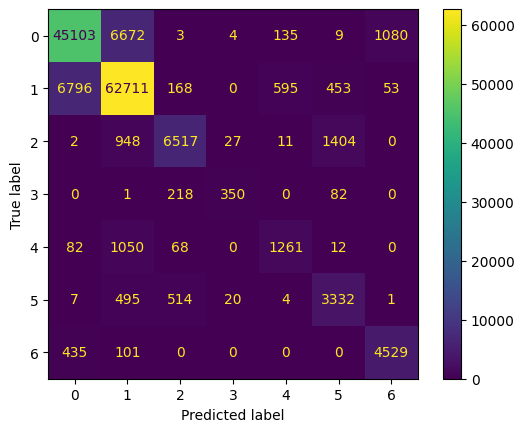

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytest, pred)).plot()

In [5]:
x = tf.random.normal((500,1)  ,seed=10) 
y = 0.1*x + x + 2 + tf.random.uniform((500,1), minval=1, maxval=2,seed=10)

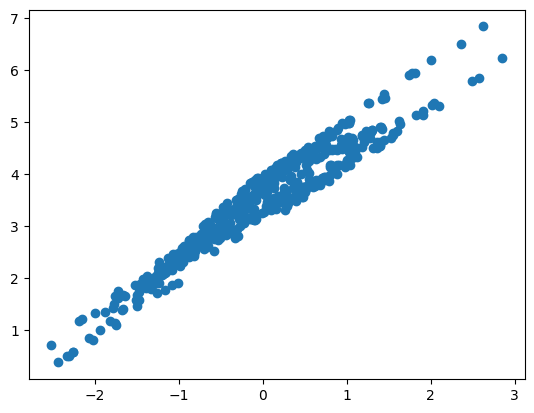

In [6]:
plt.scatter(x,y)

In [15]:

def Model():
    Dense =  partial(
        keras.layers.Dense,
        activation = keras.activations.relu,
        kernel_initializer = keras.initializers.he_normal   
    )
    model = keras.models.Sequential(
        layers=[
            Dense(2),
            Dense(2),
            Dense(2),
            Dense( units=1, kernel_initializer=keras.initializers.he_normal),
        ]
    )
    return model

In [16]:
x.shape

TensorShape([500, 1])

In [19]:
model = Model()
model.compile(
    optimizer=keras.optimizers.RMSprop(momentum=0.9),
    loss     =keras.losses.mean_absolute_error
)
model.fit(x, y, batch_size=32, epochs=10,)

Epoch 1/10
16/16 [==============================] - 2s 4ms/step - loss: 3.4704
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 3.4704
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 3.4704
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 3.4704
Epoch 5/10
16/16 [==============================] - 0s 5ms/step - loss: 3.4704
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 3.4704
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 3.4704
Epoch 8/10
16/16 [==============================] - 0s 9ms/step - loss: 3.4704
Epoch 9/10
16/16 [==============================] - 0s 5ms/step - loss: 3.4704
Epoch 10/10
16/16 [==============================] - 0s 4ms/step - loss: 3.4704


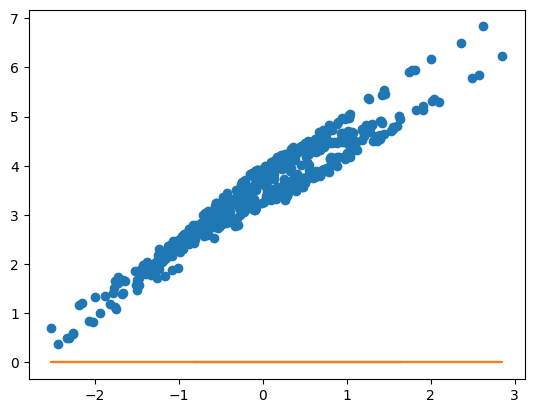

In [20]:
plt.scatter(x,y)
plt.plot(x,(model.get_weights()[3] * x))

In [144]:
model.get_weights()[3]

array([0.07771023], dtype=float32)